# The Harvard Automated Processing Pipeline in Low Electrode Electroencephalography (HAPPILEE)

## Data input
* First, the user selects which file type that will be loaded (.csv or .edf).  
[input: ```1```]
* Then, the user inputs the path to the file, including the file name.  
[input: ```offline_exp_ExG-30s.csv```]
* The number of channels is detected from the loaded data.  
* The user inputs the channel names that were recorded (e.g. Fp1, Fp2, O1, etc.).  
[input: ```POz```, ```Oz```, ```O1```, ```O2```]
* The user inputs the line frequency.  
[input: ```50```]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_input

# Loading ExG data
file_format = data_input.in_file_format()
ExGdata = data_input.in_ExGdata(file_format)
n_chan = data_input.get_n_chan(ExGdata)
ch_names = data_input.in_ch_names(n_chan)
s_rate = data_input.get_s_rate(ExGdata)
ln_freq = data_input.in_ln_freq()
A = data_input.ExG_data(file_format, ExGdata, n_chan, ch_names, s_rate, ln_freq)



In [2]:
print("File format (1: .csv, 2: .edf):", A.file_format)
print("Number of channels:", A.n_chan)
print("Timestamps (s):", A.ExGdata[0, :])
print("Channel names: ", A.ch_names)
print("Sampling rate: ", A.s_rate)
print("Line frequency: ", A.ln_freq)
print("ExGdata shape:", A.ExGdata.shape)


File format (1: .csv, 2: .edf): 1
Number of channels: 4
Timestamps (s): [0.00000000e+00 4.00000019e-03 8.00000015e-03 ... 2.99939000e+01
 2.99979000e+01 3.00019000e+01]
Channel names:  ['POz', 'Oz', 'O1', 'O2']
Sampling rate:  250
Line frequency:  50
ExGdata shape: (5, 7501)


(5, 7501)


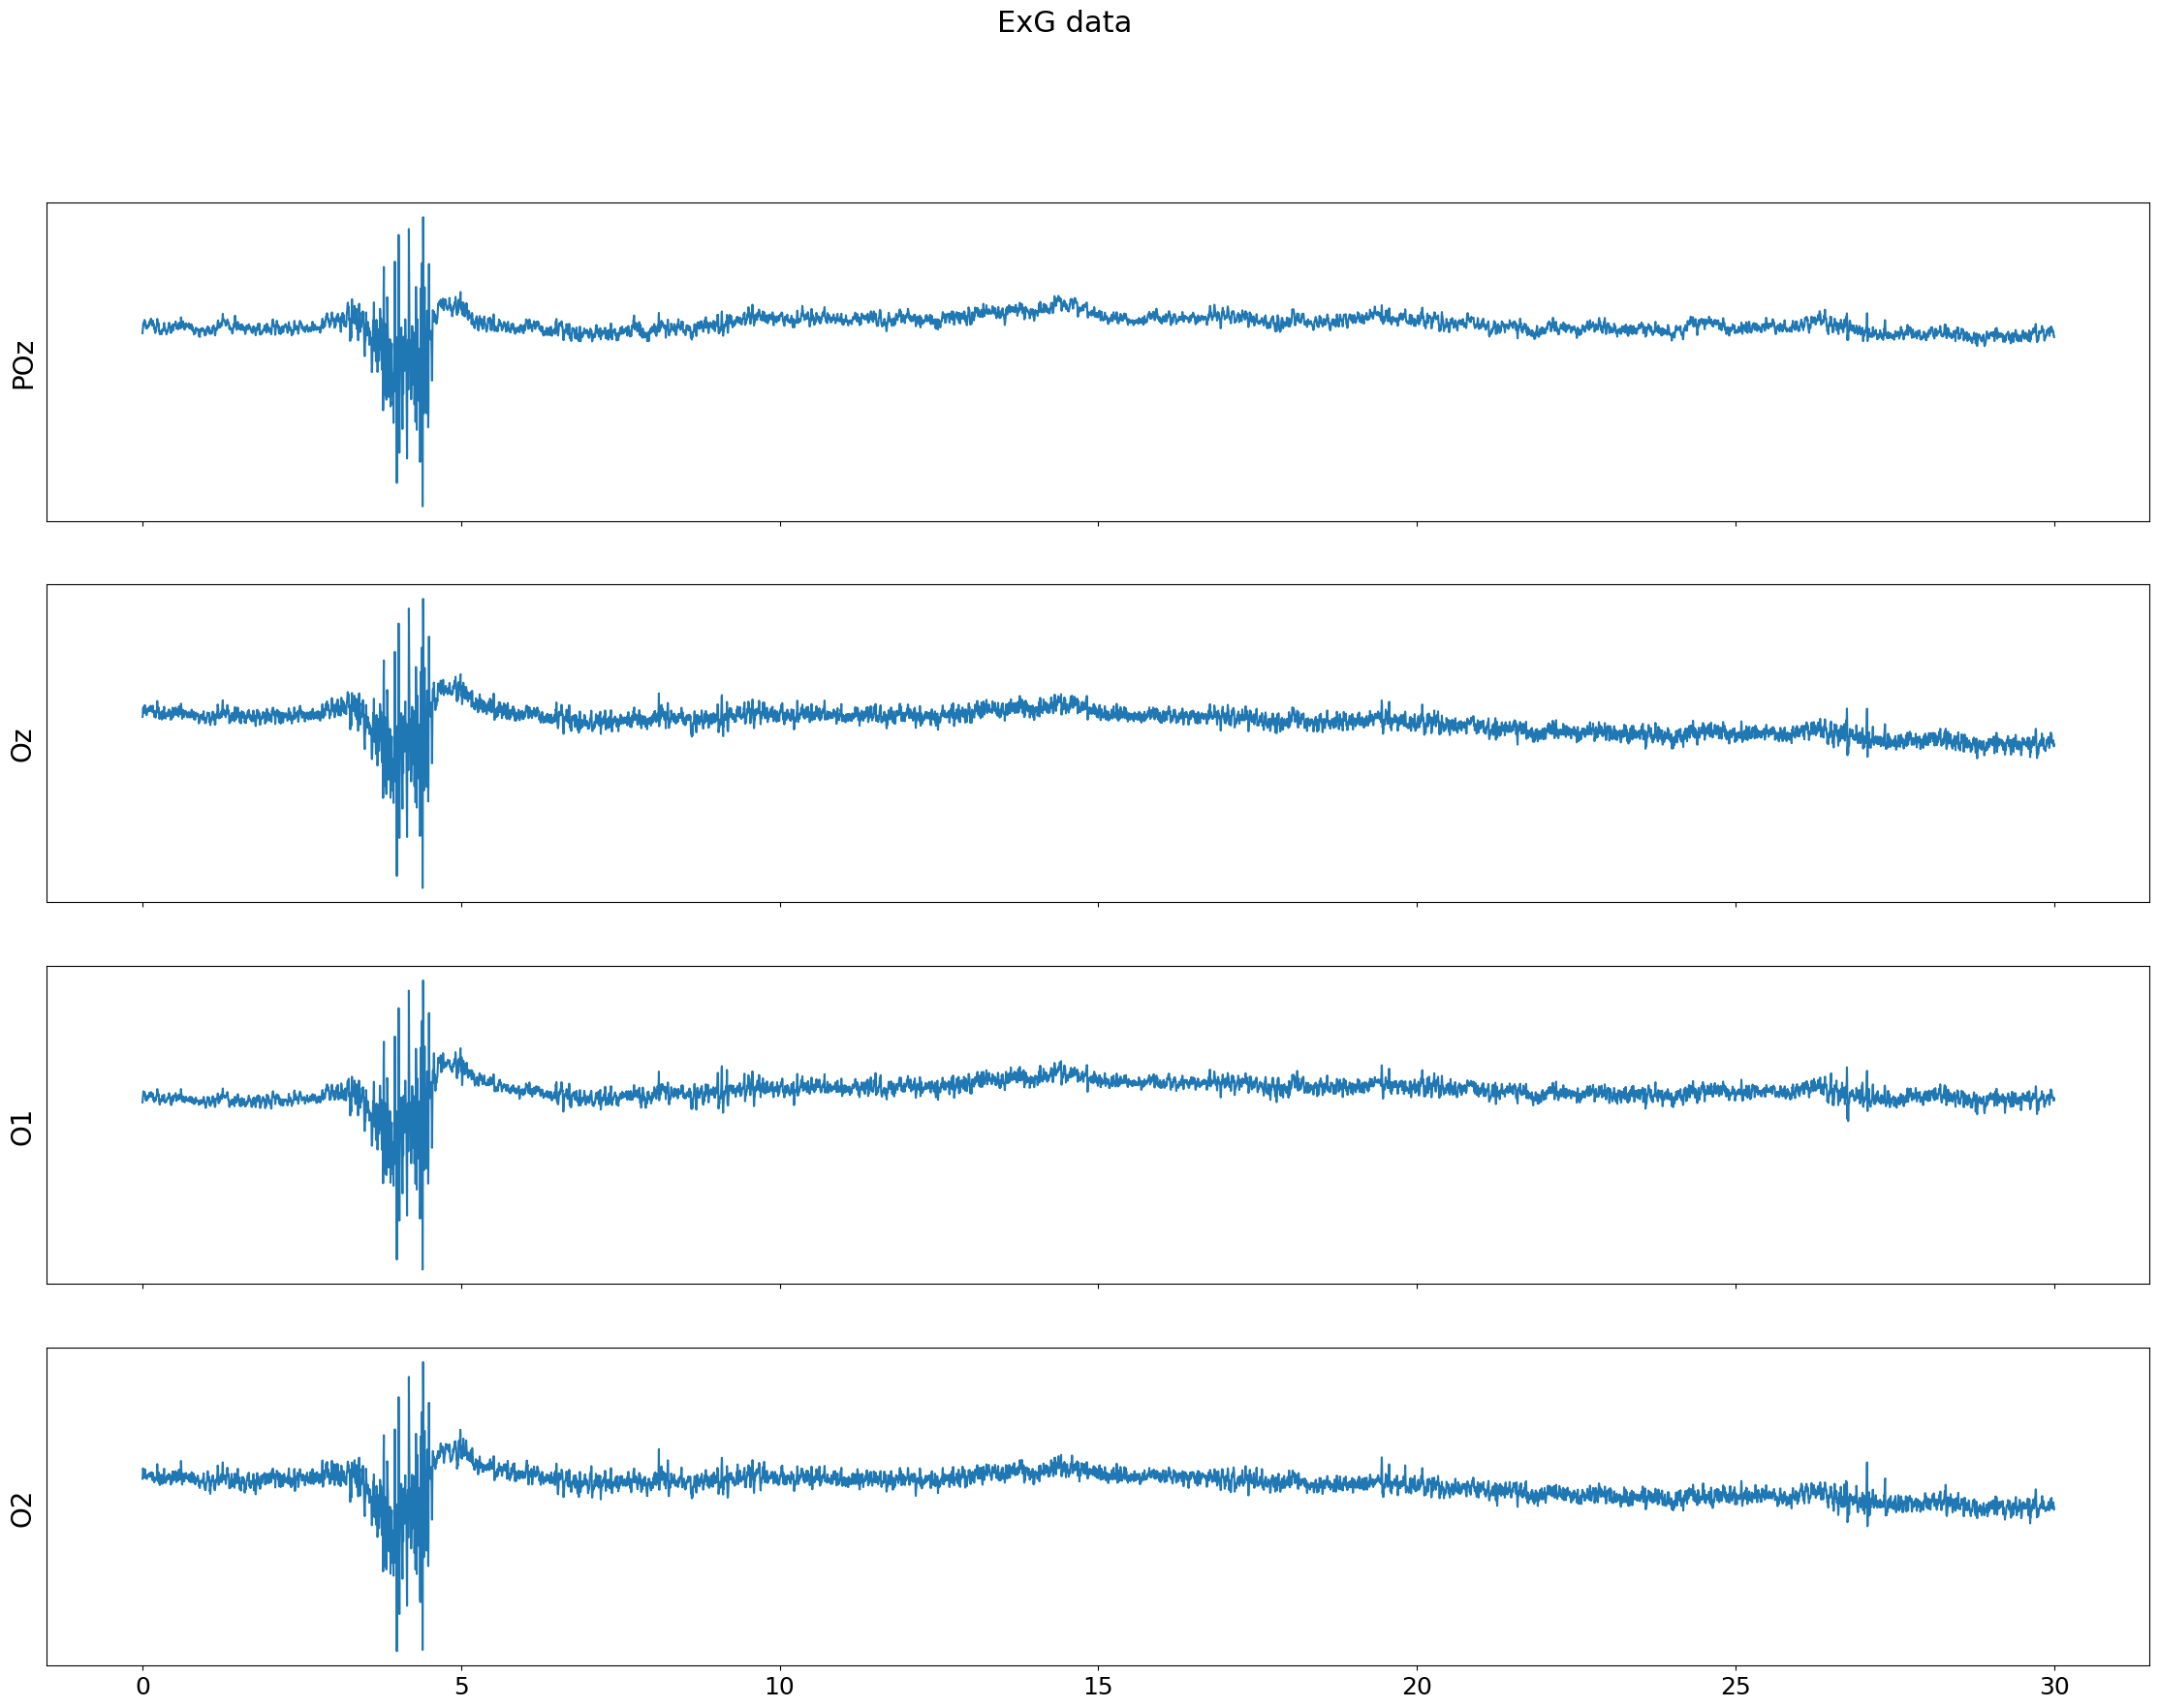

In [4]:
print(A.ExGdata.shape)
A.plot_ExGdata()


## 1. Channel Selection
* The user selects which channels to process.  
    * To process all channels, input ```all```
    * To process select channels, input ```coi```
* If ```coi``` is selected, the user inputs the selected channel names.
    * Example: ```O1```, ```O2```, ```done```

In [5]:
import ch_selection

# Select channels from the loaded data that will be processed
ExG_sel = ch_selection.select(A)

In [6]:
print("File format (1: .csv, 2: .edf):", ExG_sel.file_format)
print("Number of channels:", ExG_sel.n_chan)
print("Channel names: ", ExG_sel.ch_names)
print("Sampling rate: ", ExG_sel.s_rate)
print("Line frequency: ", ExG_sel.ln_freq)
print("ExGdata shape:", ExG_sel.ExGdata.shape)

File format (1: .csv, 2: .edf): 1
Number of channels: 1
Channel names:  ['O1']
Sampling rate:  250
Line frequency:  50
ExGdata shape: (2, 7501)


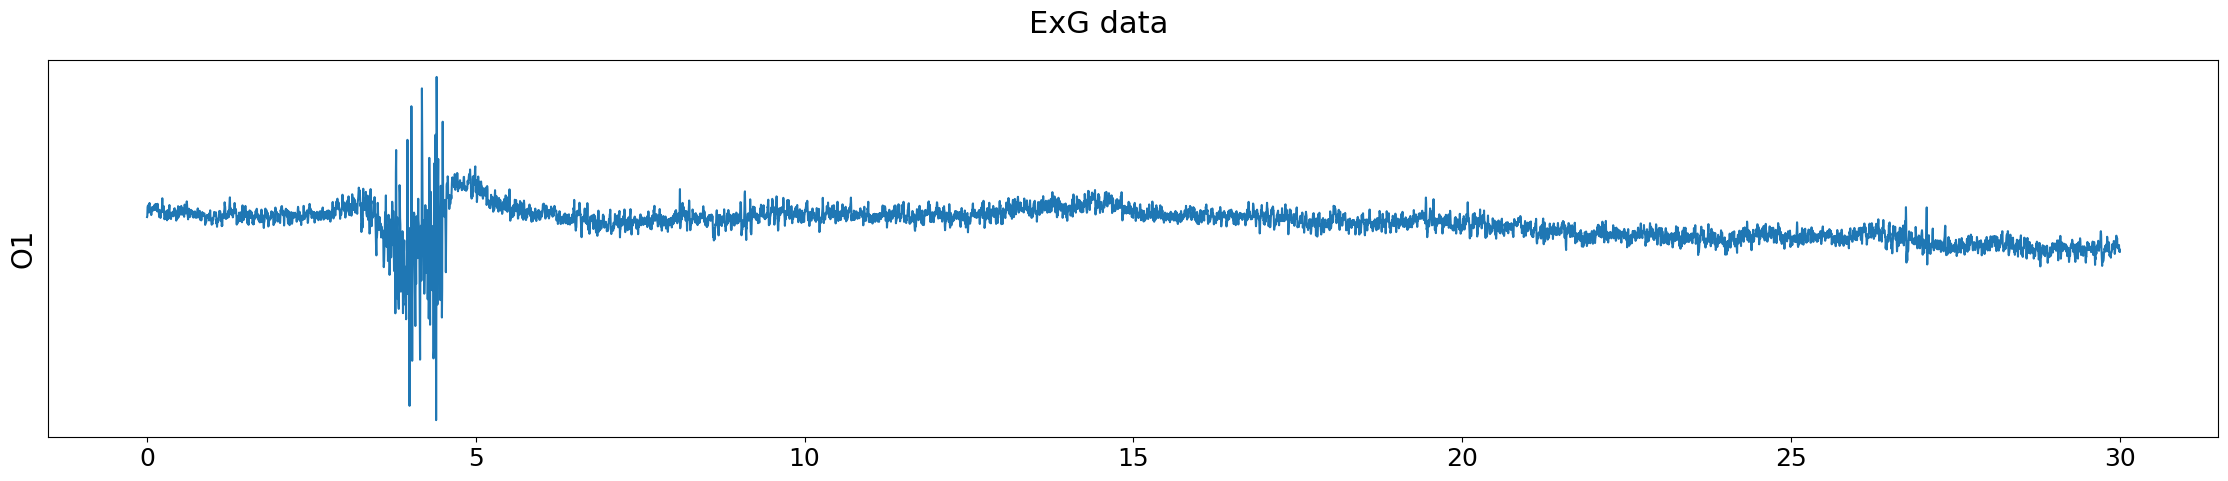

In [8]:
# Plot the selected ExG data
ExG_sel.plot_ExGdata()

## 2. Line Noise Removal

Removed notch frequencies (Hz):
     50.00 :   14 windows
    100.00 :   14 windows
(2, 7501)


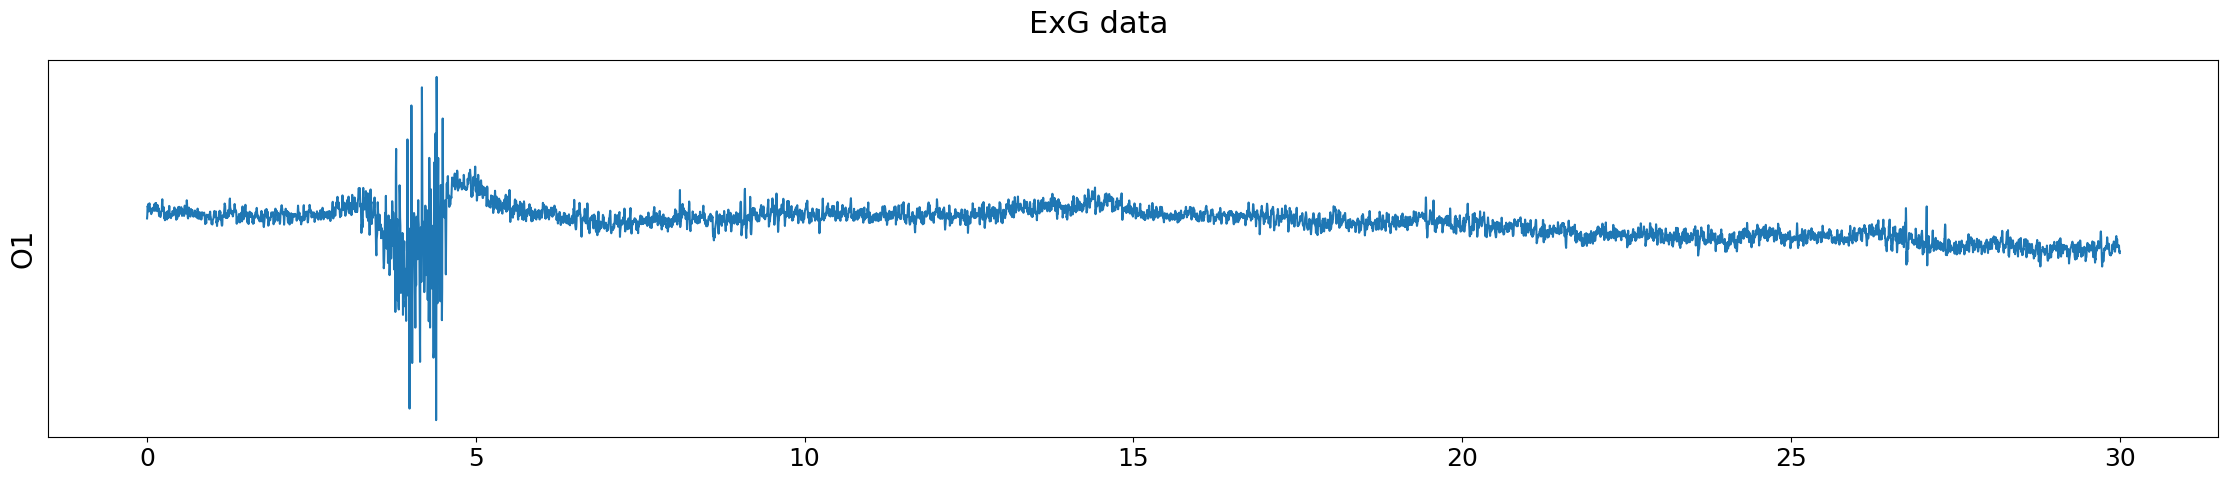

In [9]:
import ln_removal

ExG_ln_rm = ln_removal.clean_ln(ExG_sel)


print(ExG_ln_rm.ExGdata.shape)

ExG_ln_rm.plot_ExGdata()

## 3. Filtering
* Applies a low-pass filter at 100 Hz prior to artifact rejection.

Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33 samples (0.132 sec)



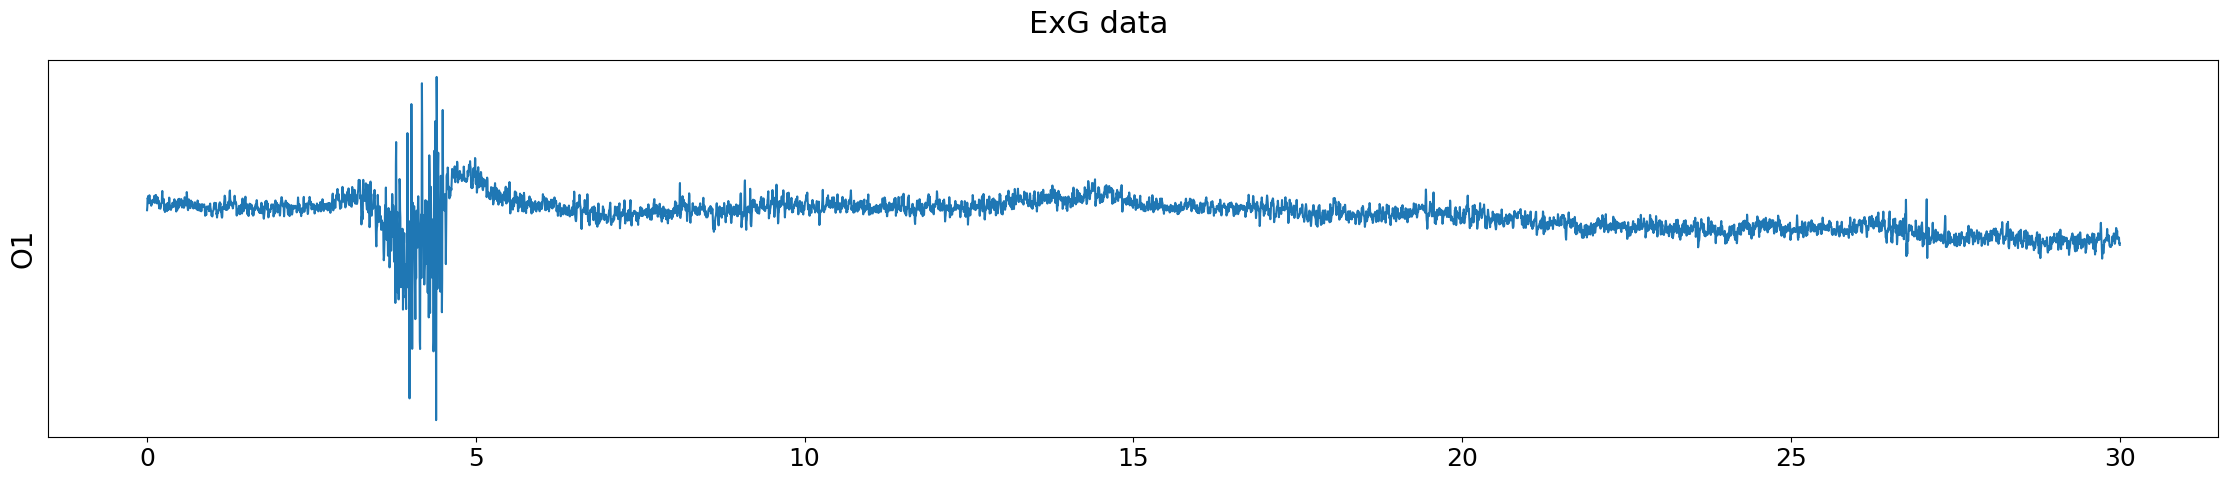

In [10]:
import filtering

ExG_lpf = filtering.lp_filt(ExG_ln_rm)
ExG_lpf.plot_ExGdata()


## 4. Bad Channel Rejection (optional)

## 5. Wavelet Thresholding
1. Wavelet Transform  
    * Each electrode’s time series is subjected to wavelet transform.
    * Chosen wavelet function: Coiflet order 4 (`coif4`)
    * Level of Data Decomposition:
        * if sampling rate > 500 Hz = `10`
        * if 250 Hz < sampling rate <= 500 Hz = `9`
        * if sampling rate <= 250 Hz = `8`
2. Determining threshold values for each level
    * Wavelet coefficients are then subjected to thresholding (in a `level-dependent` way)
    * The chosen method to determine these threshold values: `Bayes`   
    (I. M. Johnstone, B. W. Silverman (2005). [Empirical Bayes Selection of Wavelet Thresholds](https://arxiv.org/pdf/math/0508281.pdf)) 
3. Thresholding
    * Thresholding rule: `Hard`
4. Reconstruction
    * The resulting coefficients are reconstructed into a signal

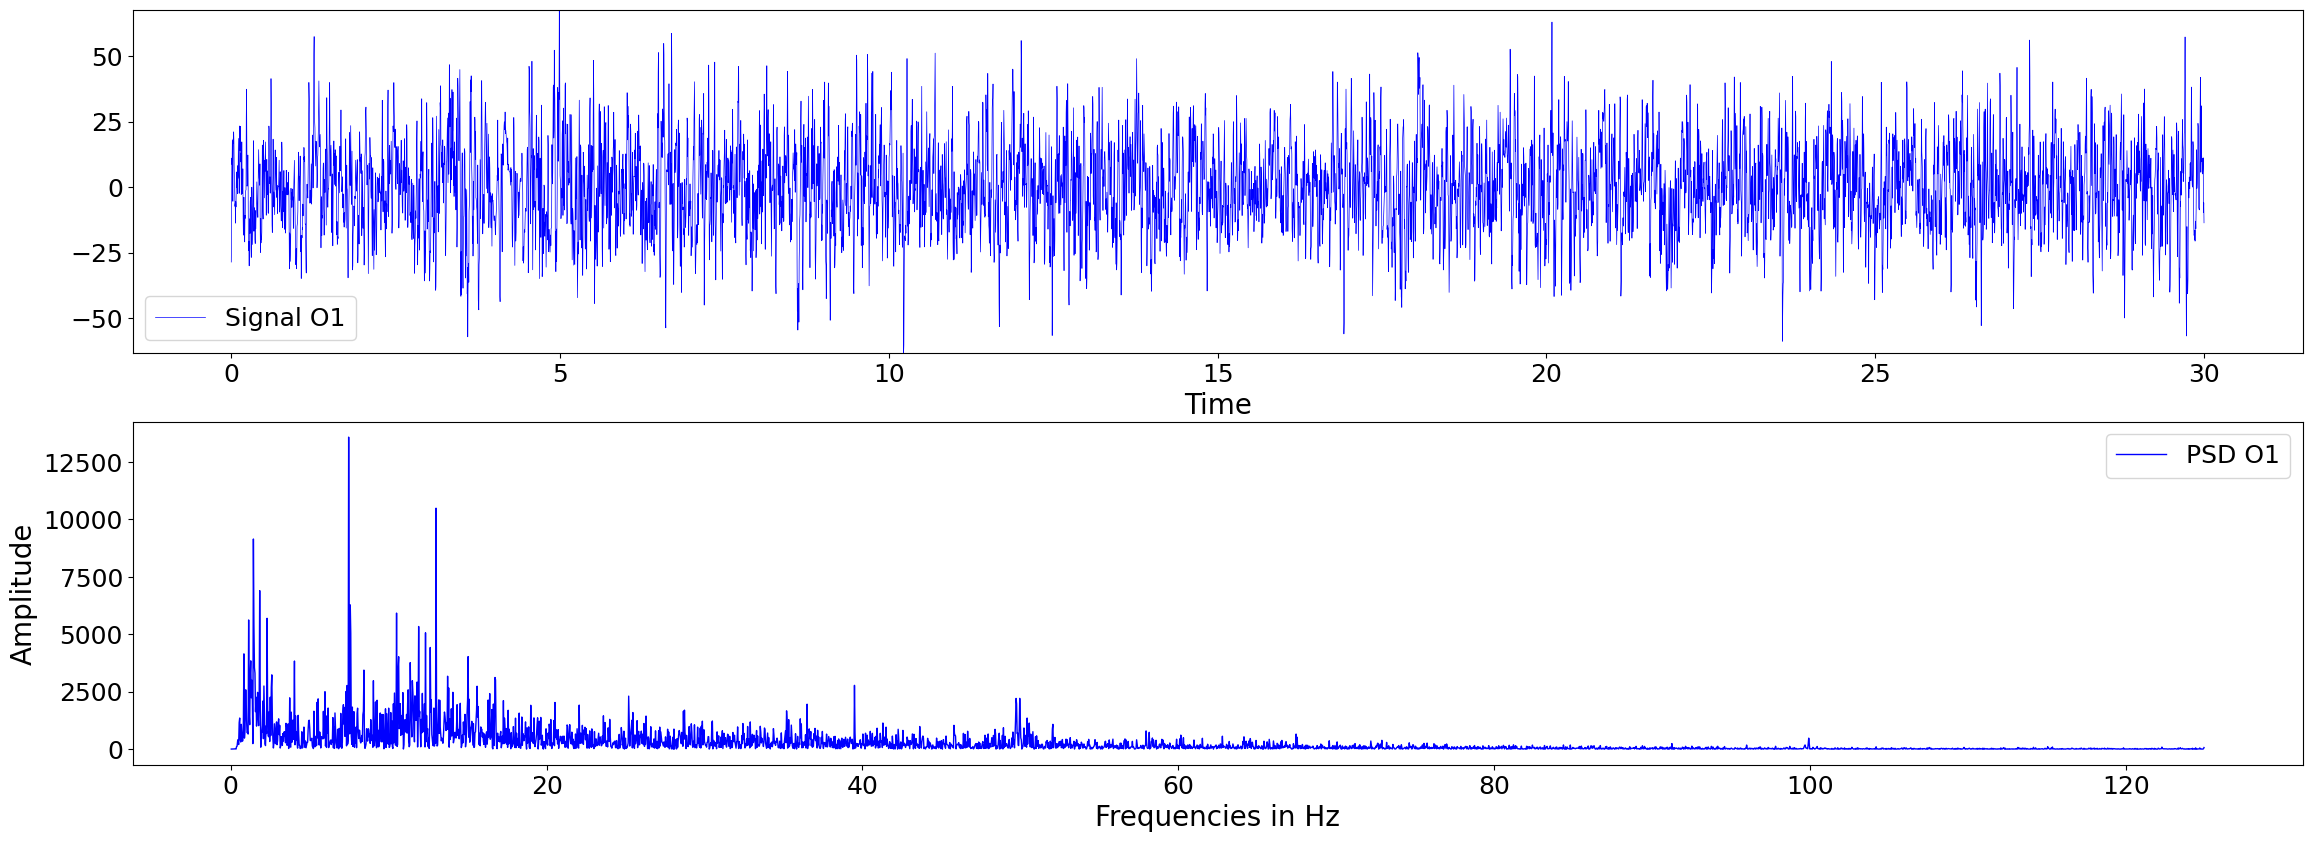

In [12]:
from wav_thresholding import wav_thresholding

ExG_wav_thd = wav_thresholding(ExG_ln_rm)
ExG_wav_thd.plot_ExGdata_psd()

### a. Universal

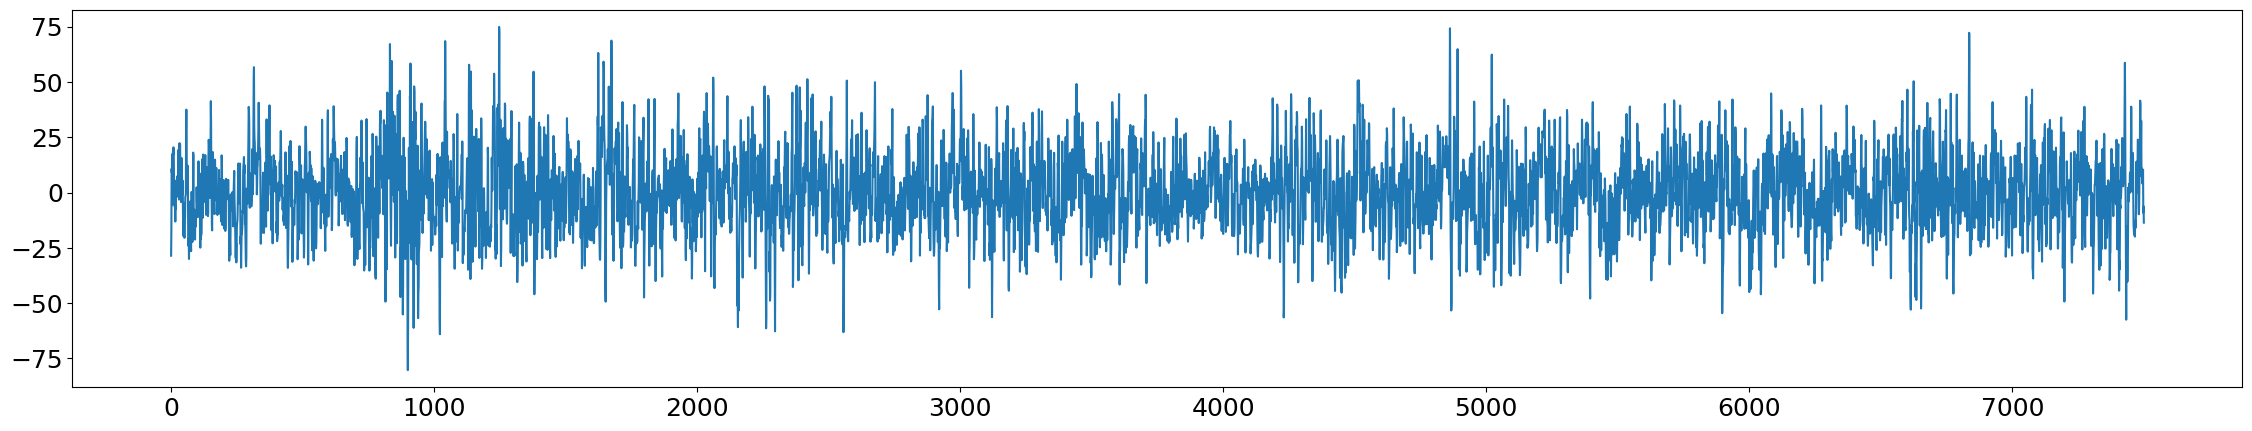

In [13]:
import numpy as np
import pywt
import matplotlib.pyplot as plt


# Universal threshold
def get_level_thd_univ(level_coef: np.array):
    """
    Calculates the threshold value for each wavelet level
    Args:
        level_coef: a numpy array containing the coefficients for the current level
    Returns:
        level_thd   : a threshold value for the current level
    """
    level_median = np.median(np.abs(level_coef))
    n = len(level_coef)
    level_thd = (level_median/0.6745) * np.sqrt(2*np.log(n))
    return level_thd


# ExG_in = np.transpose( np.genfromtxt("offline_exp_ExG-30s.csv", delimiter = ',') )
# ExG_in = ExG_in[:, 1:]
# ExG_in[0] = ExG_in[0] - ExG_in[0][0]

ExG_in = ExG_lpf.ExGdata

# 1. Wavelet transform
wavLvl = 8
coef = pywt.wavedecn(ExG_in[1, :], 
                        wavelet='coif4', 
                        level=wavLvl,
                        axes=0)


# 2. Determining threshold values for each level
level_thds = []
for level in range(1, wavLvl+1, 1): 
    get_data = coef[level].get("d") 
    level_thd = get_level_thd_univ(get_data)
    level_thds.append(level_thd)


# 3. Thresholding: hard thresholding
coef_artifacts = []
coef_artifacts.append(coef[0])
for level in range(1, wavLvl+1, 1):
    tmp = {"d": pywt.threshold(coef[level].get("d"), 
                                level_thds[level-1],
                                mode='hard')}
    coef_artifacts.append(tmp)
for level in range(1, wavLvl+1, 1): 
    get_data = coef_artifacts[level].get("d") 

# 4. Reconstruct data
artifacts = pywt.waverecn(coef_artifacts, 'coif4')
ExG_out_univ = ExG_in[1, :] - artifacts[:ExG_in.shape[1]]


plt.rcParams['figure.figsize'] = [28, 5]
plt.plot(ExG_out_univ)

## 6. Segmentation (Optional)

## 7. Re-referencing (Optional)